<a href="https://colab.research.google.com/github/nicholasanthonys/learn-gan/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Credit : Deep learning with Generative Adversarial Networks by Jakub Langr Vladimir Bok

# Generating Handwritten Digits

we will implement a GAN that learns to produce realistic-looking
handwritten digits. We will use the Python neural network library Keras with a
TensorFlow backend. Figure 3.5 shows a high-level architecture of the GAN we will
implement.


![image.png](attachment:572a490f-cc4f-477c-b3b6-54ad4e0d0354.png)!

# Importing modules and specifying model input dimensions


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Second, we specify the input dimensions of our model and dataset. Each image in
MNIST is 28 × 28 pixels with a single channel (because the images are grayscale). The
variable z_dim sets the size of the noise vector, z.


In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100

# Implementing the Generator


For simplicity, the Generator is a neural network with only a single hidden layer. It
takes in z as input and produces a 28 × 28 × 1 image. In the hidden layer, we use
the Leaky ReLU activation function. Unlike a regular ReLU function, which maps
any negative input to 0, Leaky ReLU allows a small positive gradient. This pre-
vents gradients from dying out during training, which tends to yield better training
outcomes.


At the output layer, we employ the tanh activation function, which scales the out-
put values to the range [–1, 1]. The reason for using tanh (as opposed to, say, sigmoid,
which would output values in the more typical 0 to 1 range) is that tanh tends to pro-
duce crisper images.


The following listing implements the Generator.


In [4]:
def build_generator(img_shape, z_dim) :
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Implementing the Discriminator

The Discriminator takes in a 28 × 28 × 1 image and outputs a probability indicating
whether the input is deemed real rather than fake. The Discriminator is represented
by a two-layer neural network, with 128 hidden units and a Leaky ReLU activation func-
tion at the hidden layer.



For simplicity, our Discriminator network looks almost identical to the Generator.
This does not have to be the case; indeed, in most GAN implementations, the Genera-
tor and Discriminator network architectures vary greatly in both size and complexity.


In [5]:
def build_discriminator(img_shape) :
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Building the model

we build and compile the Generator and Discriminator models imple-
mented previously. Notice that in the combined model used to train the Generator,
we keep the Discriminator parameters fixed by setting discriminator.trainable to
False. Also note that the combined model, in which the Discriminator is set to untrainable, is used to train the Generator only. The Discriminator is trained as an
independently compiled model. (This will become apparent when we review the train-
ing loop.)


We use binary cross-entropy as the loss function we are seeking to minimize
during training. Binary cross-entropy is a measure of the difference between com-
puted probabilities and actual probabilities for predictions with only two possible
classes. The greater the cross-entropy loss, the further away our predictions are from
the true labels.


To optimize each network, we use the Adam optimization algorithm. This algorithm,
whose name is derived from adaptive moment estimation, is an advanced gradient-
descent-based optimizer. The inner workings of this algorithm are beyond the scope
of this book, but it suffices to say that Adam has become the go-to optimizer for most
GAN implementations thanks to its often superior performance.


In [6]:
def build_gan (generator, discriminator) :
    # Combining the model
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [7]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

In [8]:
generator = build_generator(img_shape, z_dim)

In [9]:
# Keeps Discriminator’s parameters constant for Generator training

discriminator.trainable=False

In [10]:
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

The training code in listing 3.6 implements the GAN training algorithm. We get a ran-
dom mini-batch of MNIST images as real examples and generate a mini-batch of fake
images from random noise vectors z. We then use those to train the Discriminator net-
work while keeping the Generator’s parameters constant. Next, we generate a mini-
batch of fake images and use those to train the Generator network while keeping the
Discriminator’s parameters fixed. We repeat this for each iteration.


We use one-hot-encoded labels: 1 for real images and 0 for fake ones. To generate z, we sample from the standard normal distribution (a bell curve with 0 mean and a standard deviation of 1). The Discriminator is trained to assign fake labels to the fake
images and real labels to real images. The Generator is trained such that the Discrimi-
nator assigns real labels to the fake examples it produces.



In [11]:
losses = []
accuracies = []
iteration_checkpoints = []

In [12]:
def train(iterations, batch_size, sample_interval) :
    #load mnist data
    (X_train, _), (_, _) = mnist.load_data()
    
    # Rescales [0, 255] grayscalepixel values to [–1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    #Labels for real images: all 1s
    real = np.ones((batch_size, 1))
    
    # Labels for fake images : all 0s
    fake= np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        #Gets a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        #Generates a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        #Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # Trains the generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            #Saves losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Outputs a sample of generated images
            sample_images(generator)





# Outputting sample images

In [13]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    #Generates images from random noise
    gen_imgs = generator.predict(z)
    
    # Rescales image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    #Sets image grid
    fig, axs = plt.subplots(image_grid_rows,
        image_grid_columns,
        figsize=(4, 4),
        sharey=True,
        sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            #Outputs a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1




# Running the model

That brings us to the final step, shown in listing 3.8. We set the training hyperparame-
ters—the number of iterations and the batch size—and train the model. There is no
tried-and-true method to determine the right number of iterations or the right batch
size; we determine them experimentally through trial and error as we observe the
training progress.


That said, there are important practical constraints to these numbers: each mini-
batch must be small enough to fit inside the processing memory (typical batch sizes
people use are powers of 2: 32, 64, 128, 256, and 512). The number of iterations also
has a practical constraint: the more iterations we have, the longer the training process
takes. With complex deep learning models like GANs, this can get out of hand
quickly, even with significant computing power.


To determine the right number of iterations, we monitor the training loss and
set the iteration number around the point when the loss plateaus, indicating that we
are getting little to no incremental improvement from further training. (Because
this is a generative model, overfitting is as much a concern as it is for supervised
learning algorithms.)


In [14]:
# Sets hyperparameters
iterations = 20000 #20000
batch_size = 128
sample_interval = 1000

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.053087, acc.: 100.00%] [G loss: 3.312983]
2000 [D loss: 0.036102, acc.: 99.61%] [G loss: 5.586302]
3000 [D loss: 0.100415, acc.: 96.09%] [G loss: 4.930144]
4000 [D loss: 0.189534, acc.: 93.36%] [G loss: 3.204983]
5000 [D loss: 0.233546, acc.: 91.80%] [G loss: 3.999259]
6000 [D loss: 0.319497, acc.: 86.33%] [G loss: 3.884117]
7000 [D loss: 0.134367, acc.: 96.09%] [G loss: 4.699337]
8000 [D loss: 0.218129, acc.: 90.23%] [G loss: 3.864276]
9000 [D loss: 0.576404, acc.: 78.52%] [G loss: 2.761154]
10000 [D loss: 0.254792, acc.: 89.84%] [G loss: 3.809208]
11000 [D loss: 0.385659, acc.: 87.50%] [G loss: 3.791609]
12000 [D loss: 0.500312, acc.: 80.47%] [G loss: 3.166816]
13000 [D loss: 0.280113, acc.: 86.72%] [G loss: 2.868831]
14000 [D loss: 0.538779, acc.: 77.73%] [G loss: 3.083144]
15000 [D loss: 0.196360, acc.: 94.53%] [G loss: 4.340798]
16000 [D loss: 0.343798, acc.: 86.33%] [G loss: 2.932880]
17000 [D loss: 

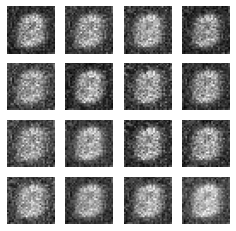

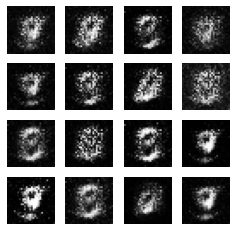

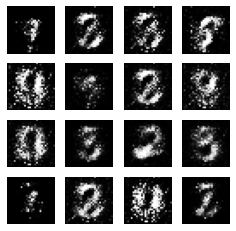

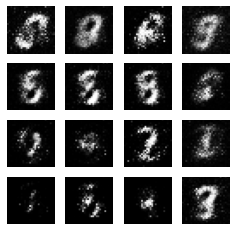

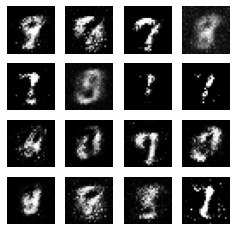

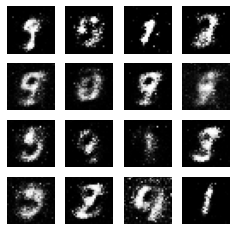

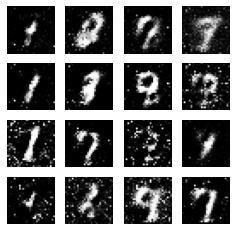

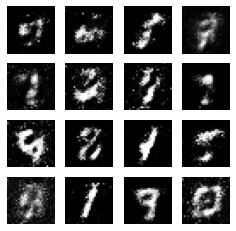

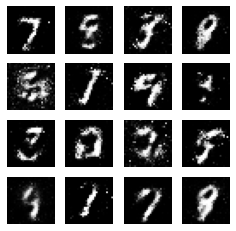

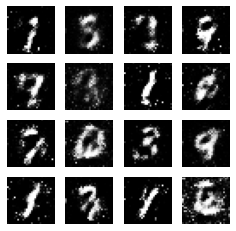

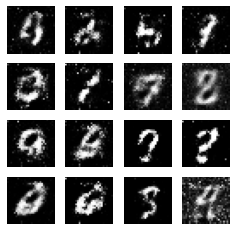

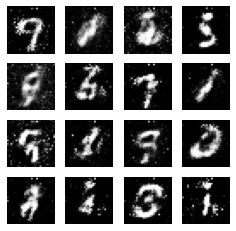

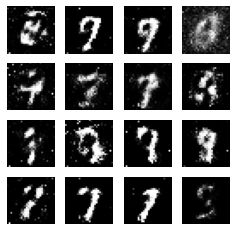

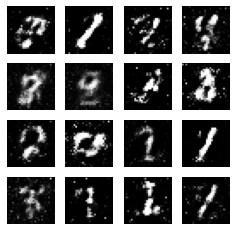

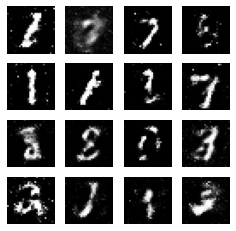

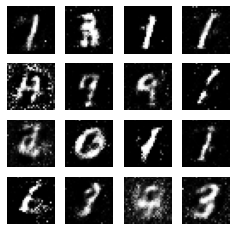

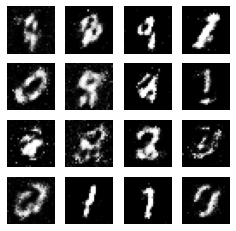

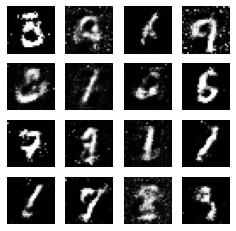

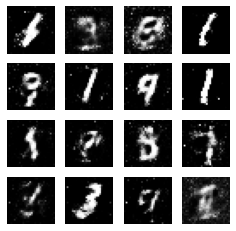

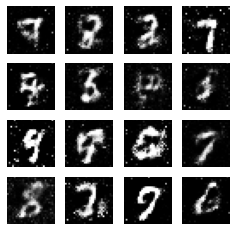

In [15]:
# Trains the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

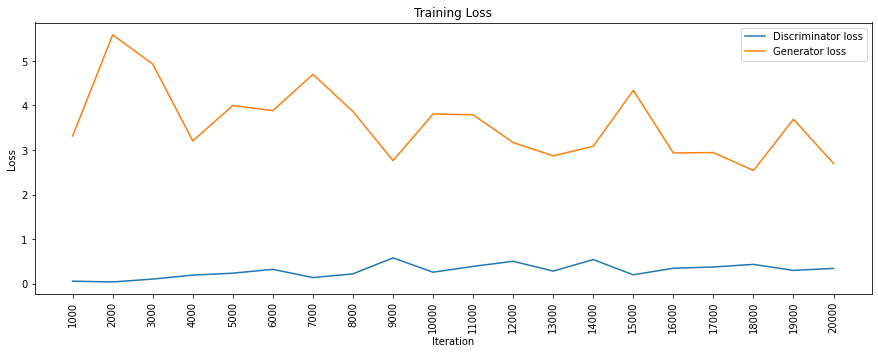

In [16]:

losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

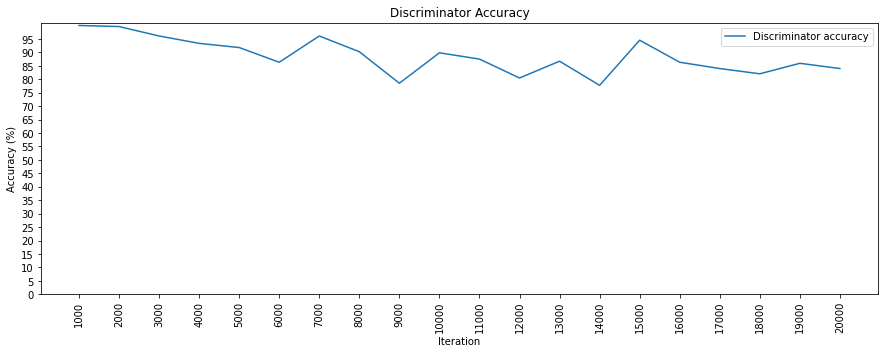

In [17]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

# Conclusion

Although the images our GAN generated are far from perfect, many of them are eas-
ily recognizable as real numerals—an impressive achievement, given that we used only
a simple two-layer network architecture for both the Generator and the Discriminator.
In the following chapter, you will learn how to improve the quality of the generated
images by using a more complex and powerful neural network architecture for the
Generator and Discriminator: convolutional neural networks.


Summary
* GANs consist of two networks: the Generator (G) and the Discriminator (D), each with its own loss function: J (G )( (G ),  (D )) and J (D )( (G ),  (D )), respectively.
* During training, the Generator and the Discriminator can tune only their own  parameters:  (G ) and  (D ), respectively.
* The two GAN networks are trained simultaneously via a game-like dynamic. The enerator seeks to maximize the Discriminator’s false-positive classifications classifying a generated image as real), while the Discriminator seeks to minimize its false-positive and false-negative classifications.
